In [1]:
!git clone https://github.com/abidlabs/contrastive

Cloning into 'contrastive'...


In [2]:
pip install contrastive


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### cPCA Preprocessing

C:\Users\laure\AppData\Local\Temp\ipykernel_37432\2013310257.py:11: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',


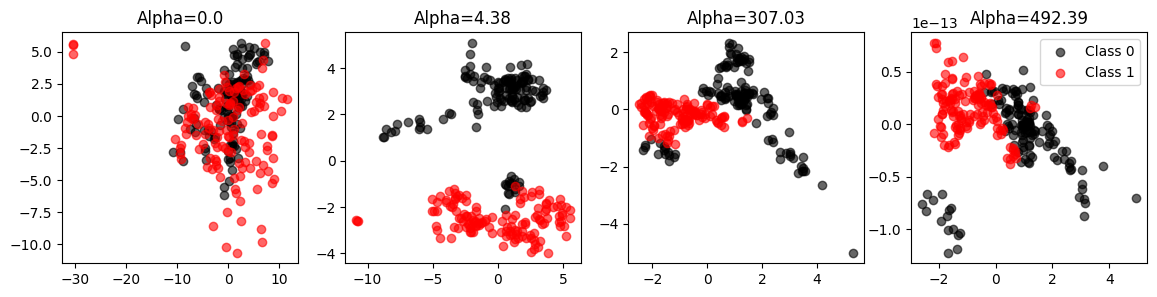

In [2]:
import os, sys, inspect
import numpy as np

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from contrastive import CPCA

DATA_CORTEX_NUCLEAR_FILEPATH = (
    "contrastive/experiments/datasets/Data_Cortex_Nuclear.csv"
)

classes = np.genfromtxt(
    DATA_CORTEX_NUCLEAR_FILEPATH,
    delimiter=",",
    skip_header=1,
    usecols=range(78, 81),
    dtype=None,
)

data = np.genfromtxt(
    DATA_CORTEX_NUCLEAR_FILEPATH,
    delimiter=",",
    skip_header=1,
    usecols=range(1, 78),
    filling_values=0,
)

target_idx_A = np.where(
    (classes[:, -1] == b"S/C")
    & (classes[:, -2] == b"Saline")
    & (classes[:, -3] == b"Control")
)[0]
target_idx_B = np.where(
    (classes[:, -1] == b"S/C")
    & (classes[:, -2] == b"Saline")
    & (classes[:, -3] == b"Ts65Dn")
)[0]

labels = len(target_idx_A) * [0] + len(target_idx_B) * [1]
target_idx = np.concatenate((target_idx_A, target_idx_B))

target = data[target_idx]

background_idx = np.where(
    (classes[:, -1] == b"C/S")
    & (classes[:, -2] == b"Saline")
    & (classes[:, -3] == b"Control")
)
background = data[background_idx]

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels)

### PCA Preprocessing

In [3]:
from sklearn.decomposition import PCA

projected_data_for_training = mdl.fit_transform(
    target, background, plot=False, active_labels=labels
)
pca = PCA(n_components=2)

X_pca_projected_data = pca.fit_transform(target)

print(X_pca_projected_data.shape)

(270, 2)


### PCA k-NN Results

In [5]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

X_data, y_data = shuffle(X_pca_projected_data, np.array(labels))

for n_neighbors in [1, 3, 5]:
    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)
    clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    count = 0

    for train_index, test_index in kf.split(X_data):
        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = (
            np.array(y_data)[train_index],
            np.array(y_data)[test_index],
        )

        clf_knn.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
        test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.8962962962962964
Val acc std: 0.030089031128281332

n_neighbors = 3
Train acc mean: 0.9527777777777778
Train acc std: 0.013545128554007208
Val acc mean: 0.8925925925925926
Val acc std: 0.037770514915502096

n_neighbors = 5
Train acc mean: 0.9296296296296296
Train acc std: 0.012896655812207492
Val acc mean: 0.8666666666666666
Val acc std: 0.03186046395200975



### cPCA k-NN Results

In [6]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# TODO: When reproducing results, ensure that ALPHAS correspond to the correct values
ALPHAS = [0, 22.85, 492.39, 623.55]
for i in range(len(projected_data_for_training)):
    X_data, y_data = shuffle(projected_data_for_training[i], np.array(labels))
    for n_neighbors in [1, 3, 5]:
        train_accuracies = []
        test_accuracies = []
        kf = KFold(n_splits=5)
        count = 0
        for train_index, test_index in kf.split(X_data):
            # print(train_index, test_index)
            clf_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

            X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
            y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

            clf_knn.fit(X_train_k, y_train_k)
            count += 1
            train_accuracies.append(clf_knn.score(X_train_k, y_train_k))
            test_accuracies.append(clf_knn.score(X_valid_k, y_valid_k))

        print(f"n_neighbors = {n_neighbors}, alpha={ALPHAS[i]}")
        print(f"Train acc mean: {np.mean(train_accuracies)}")
        print(f"Train acc std: {np.std(train_accuracies)}")
        print(f"Val acc mean: {np.mean(test_accuracies)}")
        print(f"Val acc std: {np.std(test_accuracies)}")
        print()

n_neighbors = 1, alpha=0
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.6666666666666666
Val acc std: 0.05616944773371519

n_neighbors = 3, alpha=0
Train acc mean: 0.85
Train acc std: 0.013919718868863807
Val acc mean: 0.7037037037037037
Val acc std: 0.06625386599999374

n_neighbors = 5, alpha=0
Train acc mean: 0.8018518518518519
Train acc std: 0.027529756939478695
Val acc mean: 0.6888888888888889
Val acc std: 0.06017806225656266

n_neighbors = 1, alpha=22.85
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.9777777777777776
Val acc std: 0.013857990321384994

n_neighbors = 3, alpha=22.85
Train acc mean: 0.9925925925925926
Train acc std: 0.004721314364437754
Val acc mean: 0.9814814814814815
Val acc std: 0.011712139482105127

n_neighbors = 5, alpha=22.85
Train acc mean: 0.9907407407407408
Train acc std: 0.005071505162084853
Val acc mean: 0.9777777777777776
Val acc std: 0.013857990321384994

n_neighbors = 1, alpha=492.39
Train acc mean: 1.0
Train acc std: 0.0
Val acc mean: 0.

### PCA SVM Results

In [7]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

X_data, y_data = shuffle(X_pca_projected_data, np.array(labels))

for n_neighbors in [1, 3, 5]:
    train_accuracies = []
    test_accuracies = []

    kf = KFold(n_splits=5)
    clf = SVC()
    count = 0

    for train_index, test_index in kf.split(X_data):
        X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
        y_train_k, y_valid_k = (
            np.array(y_data)[train_index],
            np.array(y_data)[test_index],
        )

        clf.fit(X_train_k, y_train_k)
        count += 1
        train_accuracies.append(clf.score(X_train_k, y_train_k))
        test_accuracies.append(clf.score(X_valid_k, y_valid_k))

    print(f"n_neighbors = {n_neighbors}")

    print(f"Train acc mean: {np.mean(train_accuracies)}")
    print(f"Train acc std: {np.std(train_accuracies)}")
    print(f"Val acc mean: {np.mean(test_accuracies)}")
    print(f"Val acc std: {np.std(test_accuracies)}")
    print()

n_neighbors = 1
Train acc mean: 0.875925925925926
Train acc std: 0.016921913780089854
Val acc mean: 0.8703703703703705
Val acc std: 0.020286020648339495

n_neighbors = 3
Train acc mean: 0.875925925925926
Train acc std: 0.016921913780089854
Val acc mean: 0.8703703703703705
Val acc std: 0.020286020648339495

n_neighbors = 5
Train acc mean: 0.875925925925926
Train acc std: 0.016921913780089854
Val acc mean: 0.8703703703703705
Val acc std: 0.020286020648339495



### cPCA SVM Results

In [8]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
import numpy as np

# TODO: When reproducing results, ensure that ALPHAS correspond to the correct values
ALPHAS = [0, 22.85, 492.39, 623.55]
for i in range(len(projected_data_for_training)):
    X_data, y_data = shuffle(projected_data_for_training[i], np.array(labels))
    for n_neighbors in [1, 3, 5]:
        train_accuracies = []
        test_accuracies = []
        kf = KFold(n_splits=5)
        count = 0
        for train_index, test_index in kf.split(X_data):
            # print(train_index, test_index)
            clf = SVC()

            X_train_k, X_valid_k = X_data[train_index], X_data[test_index]
            y_train_k, y_valid_k = y_data[train_index], y_data[test_index]

            clf.fit(X_train_k, y_train_k)
            count += 1
            train_accuracies.append(clf.score(X_train_k, y_train_k))
            test_accuracies.append(clf.score(X_valid_k, y_valid_k))

        print(f"alpha={ALPHAS[i]}")
        print(f"Train acc mean: {np.mean(train_accuracies)}")
        print(f"Train acc std: {np.std(train_accuracies)}")
        print(f"Val acc mean: {np.mean(test_accuracies)}")
        print(f"Val acc std: {np.std(test_accuracies)}")
        print()

alpha=0
Train acc mean: 0.7194444444444446
Train acc std: 0.008586683792125661
Val acc mean: 0.7074074074074074
Val acc std: 0.04596175424441057

alpha=0
Train acc mean: 0.7194444444444446
Train acc std: 0.008586683792125661
Val acc mean: 0.7074074074074074
Val acc std: 0.04596175424441057

alpha=0
Train acc mean: 0.7194444444444446
Train acc std: 0.008586683792125661
Val acc mean: 0.7074074074074074
Val acc std: 0.04596175424441057

alpha=22.85
Train acc mean: 0.9879629629629629
Train acc std: 0.00370370370370367
Val acc mean: 0.9777777777777779
Val acc std: 0.02721655269759087

alpha=22.85
Train acc mean: 0.9879629629629629
Train acc std: 0.00370370370370367
Val acc mean: 0.9777777777777779
Val acc std: 0.02721655269759087

alpha=22.85
Train acc mean: 0.9879629629629629
Train acc std: 0.00370370370370367
Val acc mean: 0.9777777777777779
Val acc std: 0.02721655269759087

alpha=492.39
Train acc mean: 0.986111111111111
Train acc std: 0.005856069741052528
Val acc mean: 0.9814814814814815